# Lat Long Analysis

This portion of our project uses the schools' latitude and longitude (previously obtained using geocoder) to perform some final cleaning on the VADIR data and then join it to the NYC crime data by location. The code below will:  

* __Load vadir data__ and cleaning it with the functions from cleandata.py  
* Ensure __schools are consistently named__ (we'll use the names from the lat long file and join them using the beds/seds code. This also means that we'll discard records from the schools for which we don't have lat/long)  
* __Fill in missing boroughs__ for records from 2006-2007.  
* __Identify felonies within a 1 mile__ radius of a given school.  
* __Plot correlations__ between school indicents and felonies (by year, by borough, by felony type, by location, by school incident type).

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from vincenty import vincenty
import cleandata as cd
import time

### Read in and clean the VADIR data from the 2006-2014 school years.

In [2]:
# Function to load and clean VADIR data
def load_and_clean_VADIR():
    """
    Function to load, join and clean VADIR (performs a series
    of functions from the cleandata module). Returns school
    dataframe ready for analysis.
    """
    # Raw data for each year
    RAW_DATA_DICT = {2006: 'VADIR_2006.xls', 2007: 'VADIR_2007.xls', 2008: 'VADIR_2008.xls', 
                     2009: 'VADIR_2009.xls', 2010: 'VADIR_2010.xls', 2011: 'VADIR_2011.xls', 
                     2012: 'VADIR_2012.xls', 2013: 'VADIR_2013.xls', 2014: 'VADIR_2014.xls'}

    # Duplicate name columns in raw files (and their replacements)
    DUP_COLS = {'County Name':'County', 'District Name': 'District', 'BEDS CODE': 'BEDS Code', 
                'False Alarm':'Bomb Threat False Alarm',
                'Other Sex offenses': 'Other Sex Offenses', 
                'Use Possession or Sale of Drugs': 'Drug Possession', 
                'Use Possession or Sale of Alcohol': 'Alcohol Possession',
                'Other Disruptive Incidents': 'Other Disruptive Incidents', 
                'Drug Possesion': 'Drug Possession', 'Alcohol Possesion': 'Alcohol Possession', 
                'Other Disruptive': 'Other Disruptive Incidents'}

    # Read in raw data and correct duplicate columns
    vadir_df = cd.vadir_concat_dfs(RAW_DATA_DICT, DUP_COLS)
    
    # Reorder columns putting demographic information first.
    DEMO_COLS = ['School Name', 'School Type', 'School Year', 'BEDS Code',  'County', 
                 'District', 'Enrollment', 'Grade Organization', 'Need/Resource Category']
    vadir_df = cd.vadir_reorder_columns(vadir_df, DEMO_COLS)
    
    # Create Columns for "Total incidents", "Incidents w/out Weapons" and "Incidents w/ Weapons"
    COLUMNS = vadir_df.columns.tolist()
    INCIDENT_COLS = [c for c in COLUMNS if c not in DEMO_COLS]
    vadir_df = cd.vadir_create_tallies(vadir_df, INCIDENT_COLS)
    
    # Consistently name county and school type, fix name capitalization, remove comment rows.
    school_df = cd.vadir_clean_concat_df(vadir_df)
    
    return school_df

In [3]:
# Function call
school_df = load_and_clean_VADIR()

# Take a look -- uncomment to run
#school_df.head(2)

... data from VADIR_2006.xls appended. Added 1455 rows for a total of 1455.
... data from VADIR_2007.xls appended. Added 1500 rows for a total of 2955.
... data from VADIR_2008.xls appended. Added 1545 rows for a total of 4500.
... data from VADIR_2009.xls appended. Added 1531 rows for a total of 6031.
... data from VADIR_2010.xls appended. Added 1678 rows for a total of 7709.
... data from VADIR_2011.xls appended. Added 1693 rows for a total of 9402.
... data from VADIR_2012.xls appended. Added 1735 rows for a total of 11137.
... data from VADIR_2013.xls appended. Added 1792 rows for a total of 12929.
... data from VADIR_2014.xls appended. Added 1805 rows for a total of 14734.


### Join School Data and Location Data

In [4]:
# read in lat-long file that contains correct names and locations
#... ??? replace this call with function call to Aaron's geocoder function???
latlon_df = pd.read_csv('SchoolLatLon.csv', index_col=0)

In [5]:
# Helper function -- extract lat/long from object type
def parse_latlong(dataframe, loc_column):
    """
    Function to extract lat/long coords. 
    INPUT: dataframe and name of column with string tuple or list pair of coordinates.
    OUTPUT: n/a. Function modifies dataframe to add a lat and long column with float type.
    """
    get_lat = lambda x: x.split(',')[0][1:] if type(x)==type('s') else np.nan
    get_long = lambda x: x.split(',')[1][:-1] if type(x)==type('s') else np.nan
    dataframe['lat'] = dataframe[loc_column].apply(get_lat).astype('float64')
    dataframe['long'] = dataframe[loc_column].apply(get_long).astype('float64')
    print('... latitude and longitude extracted for dataframe.')

In [6]:
# Helper function to add latitude and longitudes to school data frame
def join_latlong(school_df, latlon_df, talk=False):
    """
    Function to add (and parse)latitude and longitude 
    information for each school.
    INPUT: school dataframe including "BEDS Code" column,
           latitude/longitude dataframe w/ "SED CODE" col.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: dataframe with school data plut new columns 
            for 'LEGAL NAME', 'Full_Address', 'latlon'(obj),
            lat(float64) and long(float64).
    """
    # ensure BEDS and SED are integers so that they'll be recognized as identical
    latlon_df["SED CODE"] = latlon_df["SED CODE"].astype(np.int64)
    school_df["BEDS Code"] = school_df["BEDS Code"].astype(np.int64)
    
    # join latlong data to school data using the BEDS code
    school_df = pd.merge(school_df, latlon_df, left_on=['BEDS Code'],right_on=['SED CODE'], how='left')
    
    # parse latlon object in to numerical columns
    parse_latlong(school_df, 'latlon')
    
    # drop the now redundant SED code
    school_df.drop(['SED CODE'], axis=1, inplace=True)
    
    # Take a look at the resulting data/missing values
    if talk:
        print('... joined df inclues {} unique schools,'.format(len(school_df['BEDS Code'].unique())))
        schools_withloc = school_df[school_df['latlon'].notnull()]['BEDS Code'].unique()
        schools_missingloc = school_df[school_df['latlon'].isnull()]['BEDS Code'].unique()
        print('... of which {} have lat/long'.format(len(schools_withloc)),
              'and {} are missing lat/long'.format(len(schools_missingloc)))
        
    return school_df

In [7]:
# Function Call
school_df = join_latlong(school_df, latlon_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... latitude and longitude extracted for dataframe.
... joined df inclues 1967 unique schools,
... of which 1807 have lat/long and 160 are missing lat/long


### Fix School Names

In [8]:
# Helper Function
def fix_case(x):
    """Function to put a school name in the correct case"""
    if not x:
        return x
    elif x[:3] in ['PS ', 'JHS', 'MS ']:
        return x[:3] + x[3:].title()
    else:
        return x.title()

In [9]:
# Helper function to eliminate duplicated school names
def fix_school_names(school_df, talk=False):
    """ 
    INPUT: school_df with original 'School Name' column
           and with 'LEGAL NAME' column from latlong file.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: n/a, fxn modifies school_df to replace duplicate
           'School Name's with their (consistent) legal name.
    """
    if talk:
        print('... original dataset had {} unique'.format(len(school_df['School Name'].unique())),
              'school names but only {} unique BEDS Codes'.format(len(school_df['BEDS Code'].unique())))
    
    # Fix missing LEGAL NAMES with School Name
    school_df['LEGAL NAME'].fillna(school_df['School Name'], inplace=True)
    # Fix case and reassign to School Name
    school_df['School Name'] = school_df['LEGAL NAME'].apply(fix_case)
    # drop the now redundant LEGAL NAME column
    school_df.drop(['LEGAL NAME'], axis=1, inplace=True)
    
    if talk:
        print('... new dataset has {} unique school '.format(len(school_df['School Name'].unique())),
              'names and {} unique BEDS Codes.'.format(len(school_df['BEDS Code'].unique())))

In [10]:
# function call
fix_school_names(school_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... original dataset had 3135 unique school names but only 1967 unique BEDS Codes
... new dataset has 1959 unique school  names and 1967 unique BEDS Codes.


### Fill in missing boroughs

__TODO:__ From the numbers below it looks like some of the County values got switched around (eg. decrease in Manhattan counts?)... I think we probalby need a way of creating the county_map dictionary that prioritizes the traditional borough name). Come back to this.

In [ ]:
# Helper function to fill in boroughs
def fill_in_boroughs(school_df, talk=False):
    """ 
    INPUT: school_df with 'County' and 'BEDS Code' columns
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: n/a, fxn modifies school_df to fill in boroughs.
    """
    if talk:
        print('... Originally, {} entries were missing'.format(sum(school_df['County'].isnull())),
              ' county info. Other counties:\n',school_df.County.value_counts())

    # create dictionary of county by BEDS Code
    c = school_df[school_df['County'].notnull()][['BEDS Code','County']].to_dict()
    county_map = {c['BEDS Code'][idx]: c['County'][idx] for idx in c['County'].keys()}
    # map counties using dictionary
    school_df.County = school_df['BEDS Code'].map(county_map)
    
    if talk:
        print('... Now {} entries are missing'.format(sum(school_df['County'].isnull())),
              ' county info. Other counties:\n',school_df.County.value_counts())

In [ ]:
# function call
fill_in_boroughs(school_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

In [ ]:
# QUICK CHECK - are any BEDS Codes are linked with more than one Borough(County)?
school_df.groupby('BEDS Code')['County'].apply(lambda x: len(x.unique())).value_counts()

### Prep for distance sorting crime locations

In [11]:
# Helper function -- check dist
def is_in_radius(school_point, crime_point, radius):
    """
    Function using vincenty package to check distance between school and crime.
    INPUT: (lat,long) tuples for school and crime (in degrees), radius in miles.
    OUTPUT: Boolean
    """
    return vincenty(school_point, crime_point, miles=True) <= radius

In [12]:
# load NYC dataframe
felony_df = pd.read_csv('NYPD_7_Major_Felony_Incidents.csv', index_col = False)

In [ ]:
# ... and clean it   
#felony_df = cd.clean_NYPD(felony_df)
#(I'm getting and ERROR here... need to return to NYPD cleaning function)

In [13]:
# Extact Lattitude and longitude data for felony dataframes
parse_latlong(felony_df, 'Location 1')

... latitude and longitude extracted for dataframe.


In [14]:
# Testing vincenty on the first felony and first school
first_school_point = (school_df.loc[0,'lat'], school_df.loc[0,'long']) 
first_felony_point = (felony_df.loc[1,'lat'], felony_df.loc[1,'long']) 

# not w/in 2 miles, but yes, w/in 50
print('Distance: ', vincenty(first_school_point, first_felony_point))
print("... w/in 2 mi?", is_in_radius(first_school_point, first_felony_point, 2))
print("... w/in 50 mi?",is_in_radius(first_school_point, first_felony_point, 50))

Distance:  13.120085
... w/in 2 mi? False
... w/in 50 mi? True


## Function to extract crime tallies w/in radius of schools

I suspect that looping through each school is going to take forever... but we'll try that first and then explore a smarter (dynamic programming) alternative.

In [15]:
# Quick Check, are there rows with 'latlon' but not 'lat'
print('... there are {} missing latlon entries'.format(sum(school_df.latlon.isnull())))
print('... there are {} missing lat entries'.format(sum(school_df.lat.isnull())))

... there are 640 missing latlon entries
... there are 640 missing lat entries


#### Part 1: Helper functions for setting up a grid for NYC lat/long coords
NOTES: The max lat of a school is ~ 40.9  and the distance between 40.9 and 40.95 is over 3 miles... but there are 7 crimes that fell under the jurisdiction of the NY Transit police whose locations are recorded north of 41 degrees (the farthes one is 500 miles away). The minimum longitude of a school is ~-74.24 which is around 3 miles from -74.3. There are 63 crimes that occurred west of -74.3. I suggest that we disregard these outliers for the purposes of our analysis

In [16]:
# Initial exploration of ranges
max_lat = school_df.lat.max()
min_lat = school_df.lat.min()
max_long = school_df.long.max()
min_long = school_df.long.min()

lat_dist = vincenty((min_lat, 0.5*(max_long + min_long)),(max_lat, 0.5*(max_long + min_long)), miles=True)
long_dist = vincenty((min_long, 0.5*(max_lat + min_lat)),(max_long, 0.5*(max_lat + min_lat)), miles=True)

print('Latitude ranges from {} to {} with a total distance of {}'.format(min_lat, max_lat, lat_dist))
print('Longitude ranges from {} to {} with a total distance of {}'.format(min_long, max_long, long_dist))

Latitude ranges from 40.5078027 to 40.9034547 with a total distance of 27.300837
Longitude ranges from -74.2440251 to -73.4883134 with a total distance of 52.408039


In [17]:
# Helper function to identify grid cell that contains a given point
def nyc_grid(lat,long):
    """
    This function identifies a square mile cell of NYC that contains 
    the given longitude and latitude point. There are 1500 cells in 
    total. 30 rows each represent a segement of latitude and 50 
    columns each represent a segment of longitude. The cells are 
    numbered 0 through 1599 and they are unique to this analysis.
    """
    # max and min values from data set
    max_lat = 40.95
    min_lat = 40.50
    max_long = -73.45
    min_long = -74.30
    
    # divide each range into segments of a little over a mile
    delta_lat = (max_lat - min_lat)/28
    delta_long = (max_long - min_long)/48

    # then segment each direction
    lat_seg = np.array([min_lat + idx*delta_lat for idx in range(-1,29)])
    long_seg = np.array([min_long + idx*delta_long for idx in range(-1,49)])

    # identify where given point fits in segments
    row = sum(lat_seg <= lat) - 1
    col = sum(long_seg <= long) - 1
    
    # return grid number
    if row < 0 or row == 29 or col < 0 or col == 49:
        return np.nan
    else:
        return row * 50 + col

In [18]:
# Test an out of bound point
nyc_grid(40.653161, -76.862164)

nan

In [19]:
# Test an in bound point
nyc_grid(40.821798, -73.886463)

1074

In [20]:
# helper function to get a list of adjacent cells
def get_adjacent(cell_num):
    """ 
    This function identifies a group of cells which together superset 
    any points within a mile of any location in the original cell.
    INPUT: a cell number (< 5999) from NYC grid
    OUTPUT: a list of adjacent and or diagonal cell numbers
    
    NOTE: this function should only be run on cell numbers of vadir
    school locations since the nyc_grid is designed so that all
    schools are in a cell that is not a boarder cell.
    """
    col = cell_num % 50
    row = cell_num // 50
    row_range = [row - 1, row, row + 1]
    col_range = [col - 1, col, col + 1]
    return [r * 50 + c for r in row_range for c in col_range]
    

In [21]:
# Test grid adjacency
get_adjacent(52)

[1, 2, 3, 51, 52, 53, 101, 102, 103]

In [22]:
# helper function to get subset of felonies within a 1 mile radius
def get_local_crimes(location, felony_df):
    """
    This function identifies crimes less than 1 mi 
    from a single school (or GPS location).
    INPUT: location (GPS point), felony_df (w/
        'NYC_grid column already populated)
    OUTPUT: felony_df subset of crimes that 
        occurred within one mile of school.
            
    """
    cells_to_search = get_adjacent(nyc_grid(*location))
    
    # Get subset of crimes w/in grid
    cells_to_search = get_adjacent(nyc_grid(*location)) 
    crimes = felony_df.loc[felony_df.NYC_grid.isin(cells_to_search)]
    
    # Further subset by a radius of 1 mile
    if not crimes.empty: 
        r_filter = lambda x: is_in_radius(location,(x.lat,x.long),1)
        crimes =  crimes[crimes.apply(r_filter, axis=1)]
        
    return crimes

In [29]:
# test function on a single school / no crimes
this_school = school_df[school_df['BEDS Code'] == 307500014256]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

   LOCATION: (40.8213673, -73.4883134), 
   GRID CELLS: [995, 996, 997, 1045, 1046, 1047, 1095, 1096, 1097]
    ... found 0 crimes w/in 9 cells [0.15818799999942712 seconds]


In [30]:
# now testing on a school with crimes
this_school = school_df[school_df['BEDS Code'] == 307500012017]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

   LOCATION: (40.81890629999999, -73.9053333), 
   GRID CELLS: [972, 973, 974, 1022, 1023, 1024, 1072, 1073, 1074]
    ... found 61870 crimes w/in 9 cells [0.28794899999957124 seconds]
    ... of them 31860 are w/in one mile [2.7447449999999662 seconds]


#### Part 2: Crime counting function to search only within adjacent cells of the school

NOTE: loading grid cell#s for the felony data set takes 3-4 minutes and only needs to be done once. To skip that step after you've already run this function before simply set the optional parameter skip_gridsetup to True (it defaults False)

In [24]:
def tally_crime_by_loc(school_df, felony_df, skip_gridsetup = False):
    """
    Function to tally and store information about felonies 
    that occur w/in one mile of each school in the school_df.
    INPUT: school df w/ cols 'latlon', 'lat', 'long', and 'School Year'
           felony df w/ cols 'Occurrence Year', 'lat','long','Offense', and 'Identifier'
    OUTPUT: n/a, modifies school data.
    """
    if not skip_gridsetup:
        # prepare felony dataframe by adding a column for nyc_grid cell number
        felony_df.lat.fillna(0, inplace=True)
        felony_df.long.fillna(0, inplace=True)
        felony_df['NYC_grid'] = felony_df.apply(lambda x: nyc_grid(x.lat, x.long),axis=1)

    # Initialize new columns in school data frame
    school_df['CrimeIDS'] = pd.Series()
    school_df['Total Felonies w/in 1mi'] = pd.Series()
    school_df['Grand Larceny w/in 1mi'] = pd.Series()
    school_df['Robbery w/in 1mi'] = pd.Series()
    school_df['Burglary w/in 1mi'] = pd.Series()
    school_df['Assault w/in 1mi'] = pd.Series()
    school_df['Auto Theft w/in 1mi'] = pd.Series()
    school_df['Rape w/in 1mi'] = pd.Series()
    school_df['Murders w/in 1mi'] = pd.Series()
    
    # Group schools (unique location for each BEDS Code) 
    grouped = school_df[school_df.lat.notnull()].groupby(['BEDS Code'])
    
    # Loop through schools, subset crime by location. 
    for beds, df in grouped:
        # NOTE: the coordinates should all be the same so the mean is just the location
        assert len(df.lat.unique().tolist()) == 1, 'ERROR: multiple latitudes for this school.'
        location = (df.lat.mean(), df.long.mean())
        local_crimes = get_local_crimes(location, felony_df)

        # tally and store felonies for each year
        for year in df['School Year'].unique():
            subset = local_crimes[local_crimes['Occurrence Year'] == year]
            idxs = df[df['School Year'] == year].index.tolist()
            school_df.loc[idxs,['CrimeIDS']] = str(subset.Identifier.unique().tolist())
            school_df.loc[idxs,['Total Felonies w/in 1mi']] = len(subset)        
            school_df.loc[idxs,['Grand Larceny w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY')
            school_df.loc[idxs,['Robbery w/in 1mi']] = sum(subset['Offense'] == 'ROBBERY')
            school_df.loc[idxs,['Burglary w/in 1mi']] = sum(subset['Offense'] == 'BURGLARY')
            school_df.loc[idxs,['Assault w/in 1mi']] = sum(subset['Offense'] == 'FELONY ASSAULT')
            school_df.loc[idxs,['Auto Theft w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY OF MOTOR VEHICLE')
            school_df.loc[idxs,['Rape w/in 1mi']] = sum(subset['Offense'] == 'RAPE')
            school_df.loc[idxs,['Murders w/in 1mi']] = sum(subset['Offense'] == 'MURDER & NON-NEGL. MANSLAUGHTE')

    print('... tallied felonies w/in 1 mile of each school.')

In [26]:
# WARNING ... this cell takes around and hour and half to run (~5 seconds per school)
# Try importing: 'vadir_with_felonycounts.csv' for a faster option

# run function
tally_crime_by_loc(school_df, felony_df)


... calculated felony grid cells [194.06865499999998 seconds]
... found 1807 unique schools
>>> now processing: 300000010777
   LOCATION: (40.7858238, -73.9538841), 
   GRID CELLS: [869, 870, 871, 919, 920, 921, 969, 970, 971]
    ... found 77579 crimes w/in 9 cells [0.40863899999999376 seconds]
    ... of them 25264 are w/in one mile [3.3299829999999986 seconds]
    ... tallied year counts [0.08830600000001709 seconds]
   TIME: 300000010777 seconds.
>>> now processing: 307500011035
   LOCATION: (40.7640485, -73.985947), 
   GRID CELLS: [817, 818, 819, 867, 868, 869, 917, 918, 919]
    ... found 103740 crimes w/in 9 cells [0.32789099999999394 seconds]
    ... of them 59770 are w/in one mile [4.341273000000001 seconds]
    ... tallied year counts [0.681478999999996 seconds]
   TIME: 307500011035 seconds.
>>> now processing: 307500011079
   LOCATION: (40.802508800000005, -73.94237050000002), 
   GRID CELLS: [920, 921, 922, 970, 971, 972, 1020, 1021, 1022]
    ... found 71668 crimes w/in 

In [28]:
school_df.to_csv('vadir_with_felonycounts.csv')

## Exploring the data

In [31]:
# Shortcut to data - uncomment to run.
#school_df = pd.read_csv('vadir_with_felonycounts.csv')

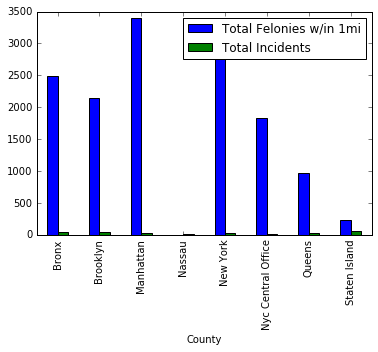

In [35]:
school_df.groupby('County')['Robbery w/in 1mi','Total Incidents'].mean().plot(kind='bar', legend=True)

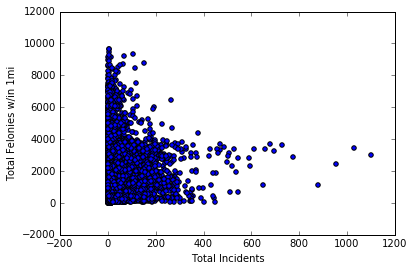

In [36]:
school_df.plot(x='Total Incidents', y='Total Felonies w/in 1mi', kind='scatter')

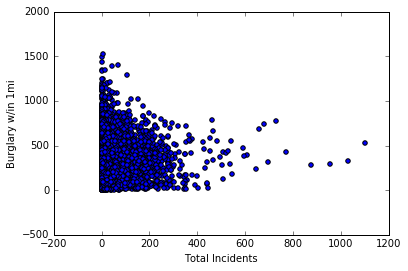

In [43]:
school_df.plot(x='Total Incidents' , y='Burglary w/in 1mi', kind='scatter')

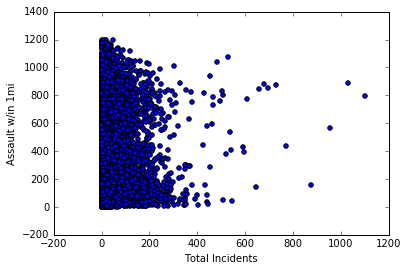

In [45]:
school_df.plot(x='Total Incidents' , y='Assault w/in 1mi', kind='scatter')

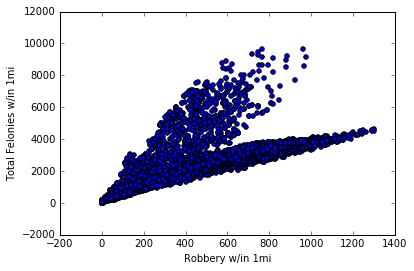

In [38]:
school_df.plot(x='Robbery w/in 1mi' , y='Total Felonies w/in 1mi', kind='scatter')

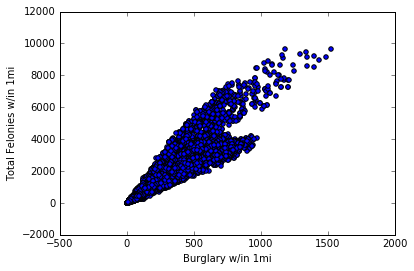

In [39]:
school_df.plot(x='Burglary w/in 1mi' , y='Total Felonies w/in 1mi', kind='scatter')

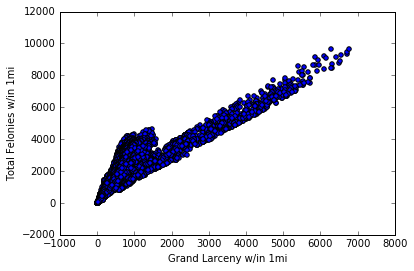

In [40]:
school_df.plot(x='Grand Larceny w/in 1mi' , y='Total Felonies w/in 1mi', kind='scatter')